In [26]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from google.colab import drive
drive.mount('/content/drive')


FILEPATH = "/content/drive/MyDrive/AAPL.csv"
aapl_data = pd.read_csv(FILEPATH, index_col=0, parse_dates=True)
returns = aapl_data['Adj_Close'].pct_change().dropna().rename('Rets')
returns

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Rets
Date,
2010-01-05 00:00:00+00:00,0.001729
2010-01-06 00:00:00+00:00,-0.015906
2010-01-07 00:00:00+00:00,-0.001849
2010-01-08 00:00:00+00:00,0.006648
2010-01-11 00:00:00+00:00,-0.008821
...,...
2020-12-23 00:00:00+00:00,-0.006976
2020-12-24 00:00:00+00:00,0.007712
2020-12-28 00:00:00+00:00,0.035766


# **Evaluate strategy performance during high volatility periods**

[*********************100%***********************]  1 of 1 completed


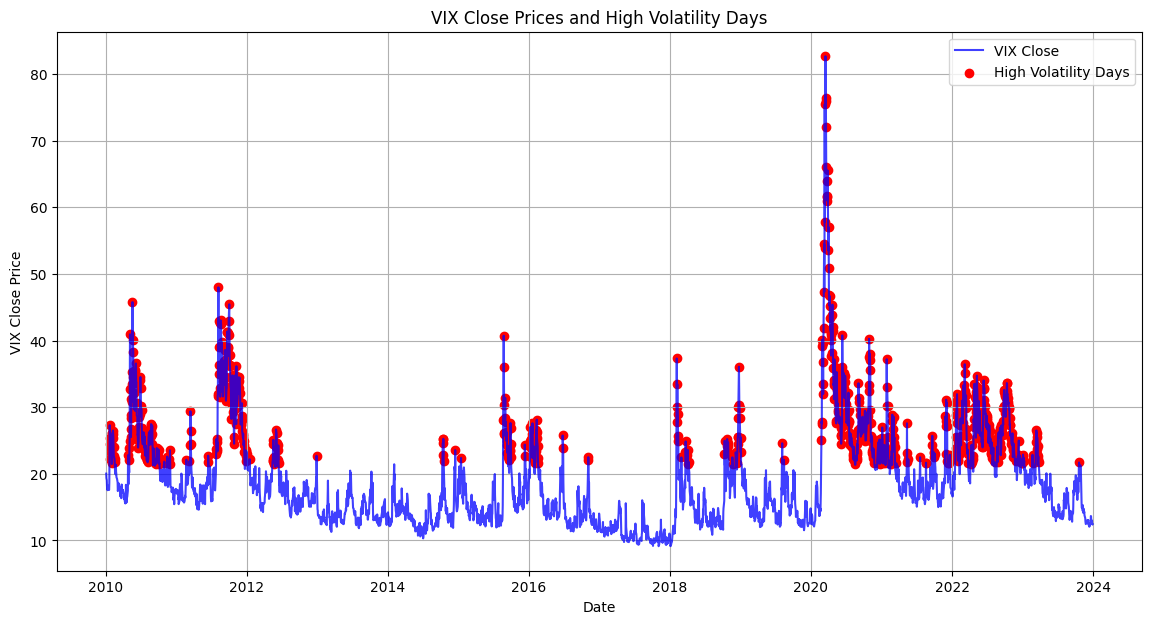

In [27]:
# Download VIX data
def download_vix_data():
    vix = yf.download("^VIX", start="2010-01-01", end="2023-12-31")  # Adjust dates as needed
    vix = vix[['Close']]  # We're interested in the 'Close' prices only
    vix.rename(columns={'Close': 'VIX_Close'}, inplace=True)
    return vix

# Calculate volatility threshold
def calculate_volatility_threshold(vix_df, percentile=0.75):
    threshold = vix_df['VIX_Close'].quantile(percentile)
    return threshold

# Flag high volatility days
def flag_high_volatility_days(vix_df, threshold):
    vix_df['high_volatility'] = vix_df['VIX_Close'] > threshold
    return vix_df

# Plot VIX and high volatility days
def plot_vix_and_high_vol_days(vix_df):
    plt.figure(figsize=(14, 7))
    plt.plot(vix_df.index, vix_df['VIX_Close'], label='VIX Close', color='blue', alpha=0.75)
    # Highlight high volatility days
    plt.scatter(vix_df.index[vix_df['high_volatility']], vix_df['VIX_Close'][vix_df['high_volatility']],
                color='red', label='High Volatility Days')
    plt.title('VIX Close Prices and High Volatility Days')
    plt.xlabel('Date')
    plt.ylabel('VIX Close Price')
    plt.legend()
    plt.grid(True)
    plt.show()

# Main execution
vix = download_vix_data()
threshold = calculate_volatility_threshold(vix)
vix = flag_high_volatility_days(vix, threshold)
plot_vix_and_high_vol_days(vix)

In [28]:
# Convert the returns series into a DataFrame for easier merging
returns_df = pd.DataFrame(returns)

In [29]:
print("Returns DataFrame index level:")
print(returns_df.index.nlevels)

print("VIX DataFrame index level:")
print(vix.index.nlevels)


Returns DataFrame index level:
1
VIX DataFrame index level:
1


In [30]:
# Use single brackets to ensure 'high_volatility' is treated as a Series, not a DataFrame
combined_data = returns_df.join(vix['high_volatility'], how='left')
combined_data['high_volatility'].fillna(False, inplace=True)  # Fill NaNs with False

# Display the head of the combined data to check if the join was successful
print(combined_data.head())

                               Rets  high_volatility
Date                                                
2010-01-05 00:00:00+00:00  0.001729            False
2010-01-06 00:00:00+00:00 -0.015906            False
2010-01-07 00:00:00+00:00 -0.001849            False
2010-01-08 00:00:00+00:00  0.006648            False
2010-01-11 00:00:00+00:00 -0.008821            False


<ipython-input-30-80ed27612723>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_data['high_volatility'].fillna(False, inplace=True)  # Fill NaNs with False


In [31]:
# Calculate descriptive statistics for returns on high volatility vs. normal volatility days
high_vol_stats = combined_data[combined_data['high_volatility']]['Rets'].describe()
normal_vol_stats = combined_data[~combined_data['high_volatility']]['Rets'].describe()

print("Statistics for High Volatility Days:")
print(high_vol_stats)
print("\nStatistics for Normal Volatility Days:")
print(normal_vol_stats)


Statistics for High Volatility Days:
count    590.000000
mean      -0.000571
std        0.025587
min       -0.128647
25%       -0.013902
50%       -0.000924
75%        0.013255
max        0.119809
Name: Rets, dtype: float64

Statistics for Normal Volatility Days:
count    2177.000000
mean        0.001740
std         0.015030
min        -0.123558
25%        -0.005751
50%         0.001292
75%         0.009823
max         0.088741
Name: Rets, dtype: float64


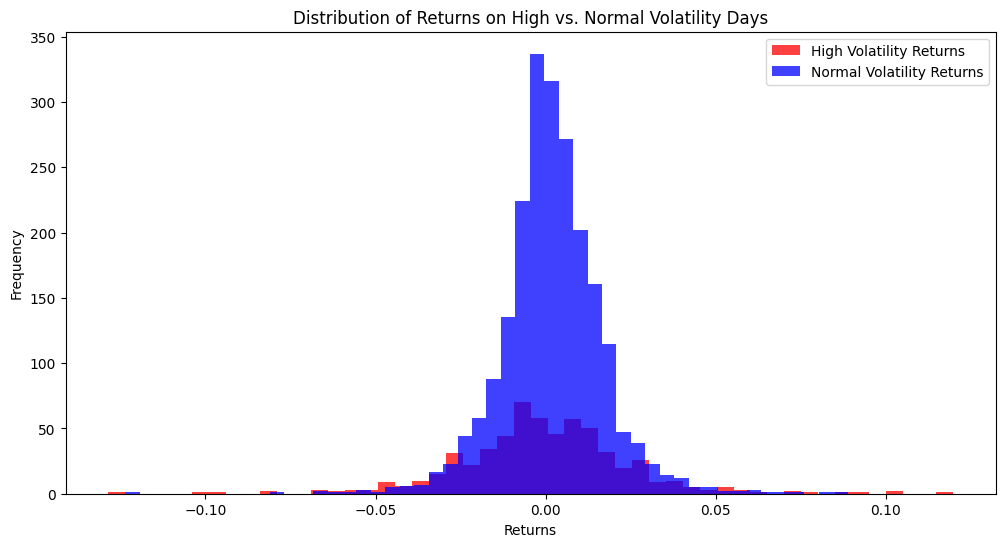

In [32]:
# Plotting the returns on high vs. normal volatility days
plt.figure(figsize=(12, 6))
plt.hist(combined_data[combined_data['high_volatility']]['Rets'], bins=50, alpha=0.75, color='red', label='High Volatility Returns')
plt.hist(combined_data[~combined_data['high_volatility']]['Rets'], bins=50, alpha=0.75, color='blue', label='Normal Volatility Returns')
plt.title('Distribution of Returns on High vs. Normal Volatility Days')
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [25]:
# Mean, Volatility, and Sharpe Ratio calculations
mean_high_vol = combined_data[combined_data['high_volatility']]['Rets'].mean()
mean_normal_vol = combined_data[~combined_data['high_volatility']]['Rets'].mean()
std_high_vol = combined_data[combined_data['high_volatility']]['Rets'].std()
std_normal_vol = combined_data[~combined_data['high_volatility']]['Rets'].std()
sharpe_high_vol = mean_high_vol / std_high_vol if std_high_vol != 0 else float('inf')
sharpe_normal_vol = mean_normal_vol / std_normal_vol if std_normal_vol != 0 else float('inf')

print(f"Mean Returns - High Vol: {mean_high_vol}, Normal Vol: {mean_normal_vol}")
print(f"Volatility - High Vol: {std_high_vol}, Normal Vol: {std_normal_vol}")
print(f"Sharpe Ratio - High Vol: {sharpe_high_vol}, Normal Vol: {sharpe_normal_vol}")


Mean Returns - High Vol: -0.0005711604733112815, Normal Vol: 0.0017403320502071642
Volatility - High Vol: 0.02558667325794995, Normal Vol: 0.015029582774123957
Sharpe Ratio - High Vol: -0.022322576583253866, Normal Vol: 0.11579376995104938
